In [ ]:
import json
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = "/content/drive/MyDrive/CV Project 2"

In [ ]:
image_folder = os.path.join(root, 'images')

In [ ]:
# Read the JSON file
with open(os.path.join(root, "groundtruth.json"), 'r') as file:
    json_data = file.read()

In [ ]:
# Convert JSON to Python dictionary
dictionary = json.loads(json_data)

In [ ]:
len(os.listdir(os.path.join(root, 'images')))

1491

In [ ]:

X = []
file_names = []

for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)
    image = cv2.imread(file_path)
    if image is not None:
        resized_image = cv2.resize(image, (128, 128))
        X.append(resized_image)
        file_names.append(filename)

In [ ]:
X = np.asarray(X)

In [ ]:
X.shape

(1491, 128, 128, 3)

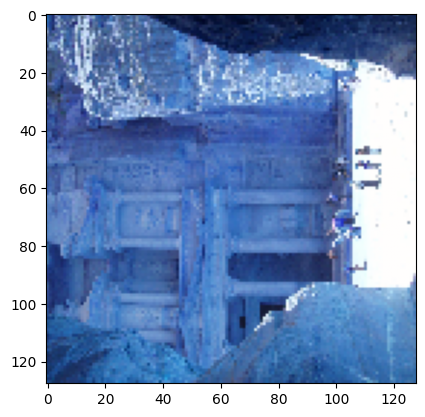

In [ ]:
plt.imshow(X[0]/255)
plt.show()

In [ ]:
X_bw = []
for img in X:
    X_bw.append(cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2GRAY))

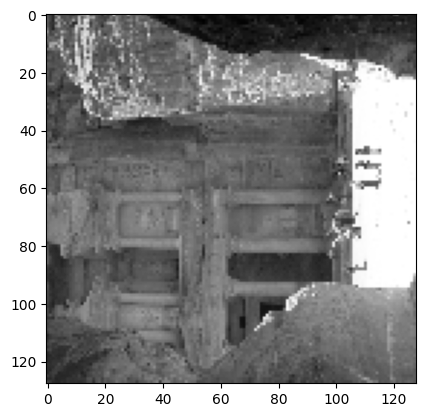

In [ ]:
plt.imshow(X_bw[0], cmap="gray")
plt.show()

In [ ]:
extractor = cv2.xfeatures2d.SIFT_create()

In [ ]:
# initialize lists where we will store *all* keypoints and descriptors
X2 = []
file_names2 = []
keypoints = []
descriptors = []

for i, img in enumerate(X_bw):
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(cv2.convertScaleAbs(img), None)
    if img_keypoints is None or img_descriptors is None:
        print("None")
        continue
    X2.append(img)
    file_names2.append(file_names[i])
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)


None
None
None
None
None
None
None
None


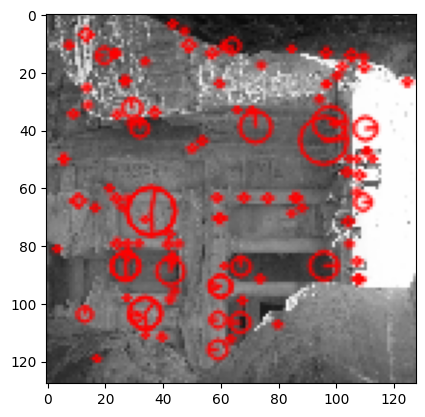

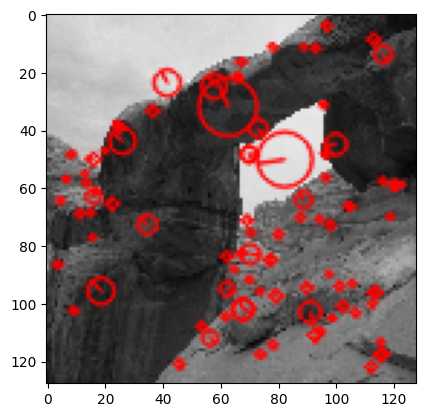

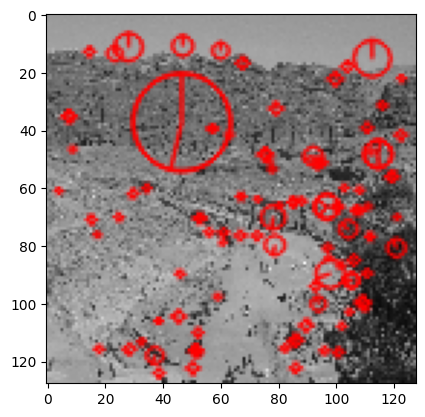

In [ ]:
output_image = []
for i in range(3):
    output_image.append(cv2.drawKeypoints(cv2.convertScaleAbs(X2[i]), keypoints[i], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[i], cmap='gray')
    plt.show()

In [ ]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [ ]:

# check the shape 
all_descriptors.shape

(176812, 128)

In [ ]:
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [ ]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
visual_words[0][:5]

array([ 13, 195, 169,  88, 123], dtype=int32)

In [ ]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

(1483, 200)

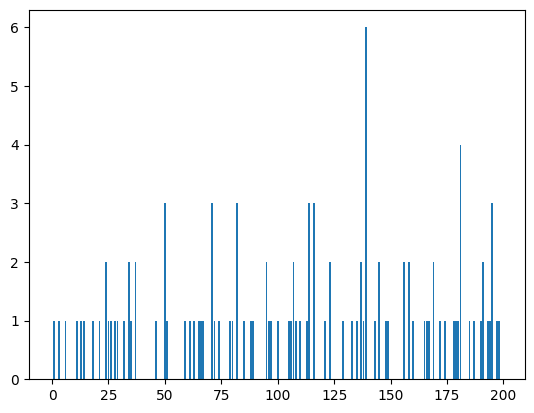

In [ ]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

In [ ]:
# N is the number of images, i.e. the size of the dataset
N = 19967

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [ ]:
idf = np.log(N/ df)
idf.shape, idf[:5]

((200,), array([4.01019198, 3.61026705, 3.57389941, 3.49166131, 3.53536574]))

In [ ]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((1483, 200),
 array([0.        , 3.61026705, 0.        , 3.49166131, 0.        ]))

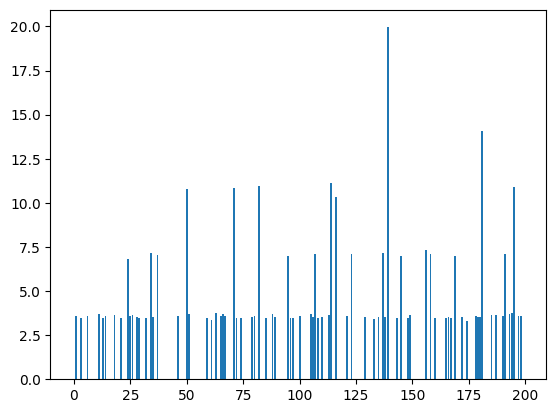

In [ ]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

In [ ]:
top_k = 4

In [ ]:
name_to_ind = {}
for i, img_name in enumerate(file_names2):
    name_to_ind[img_name] = i

Query Image


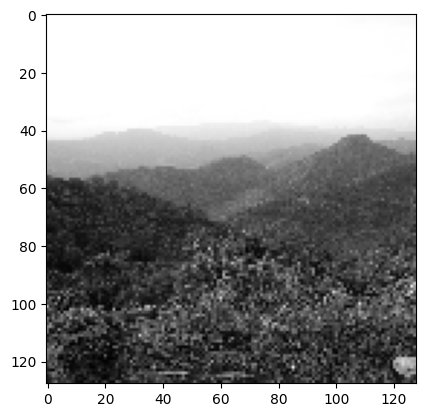

992: 1.0


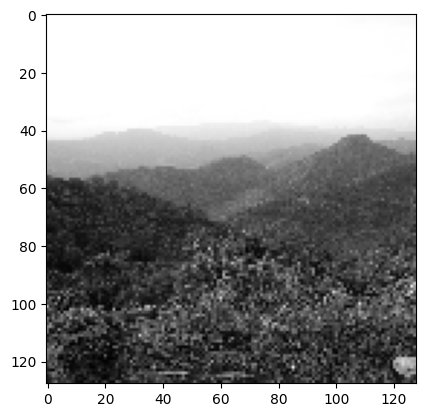

1126: 0.5402


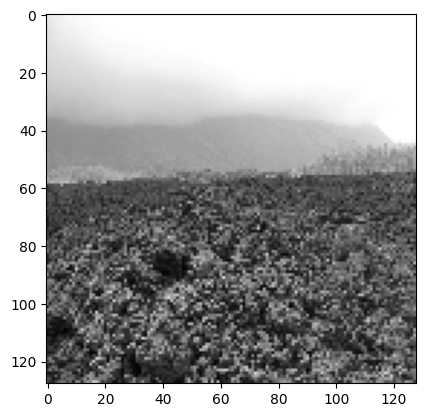

471: 0.5184


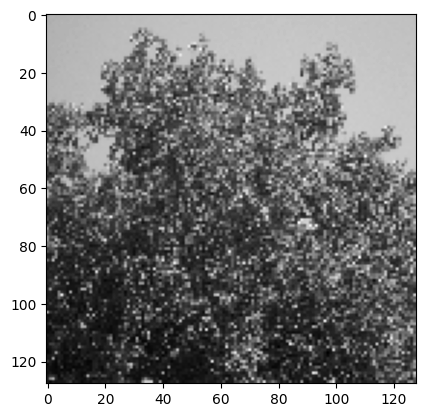

1104: 0.4655


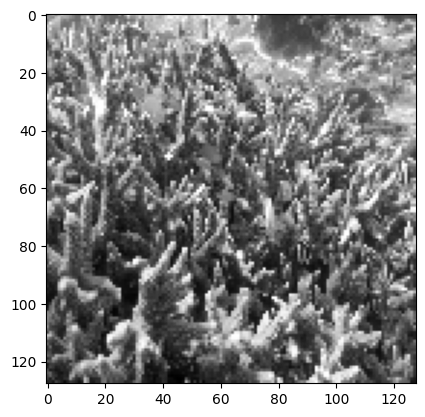

In [ ]:
from numpy.linalg import norm

# Output for one query

value = dictionary['0']

i = name_to_ind[value['query']]
a = tfidf[i]
b = tfidf  

cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
idx = np.argsort(-cosine_similarity)[:top_k]

print("Query Image")
plt.imshow(X2[i], cmap='gray')
plt.show()

for j in idx:
    print(f"{j}: {round(cosine_similarity[j], 4)}")
    plt.imshow(X2[j], cmap='gray')
    plt.show()

In [ ]:
output = {}

for key in dictionary.keys():
    value = dictionary[key]

    if value['query'] not in name_to_ind.keys():
        continue
    i = name_to_ind[value['query']]
    a = tfidf[i]
    b = tfidf  

    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_k]

    temp = []
    for j in idx[1:]:
        temp.append(file_names2[j])
    output[key] = temp

In [ ]:
with open(os.path.join(root, 'vbow_output.json'), 'w') as json_file:
    json.dump(output, json_file)